In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
from tqdm import tqdm
from keras.models import Model

In [2]:
!cp -r /content/drive/MyDrive/DsComp /content/DS

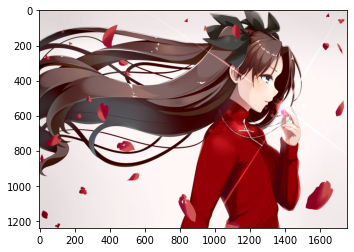

In [36]:
image_Rin = cv.imread('/content/drive/MyDrive/DataSet/Rin Tohsaka/20211215_015150.jpg')
image_Rin = cv.cvtColor(image_Rin, cv.COLOR_BGR2RGB)
plt.imshow(image_Rin)

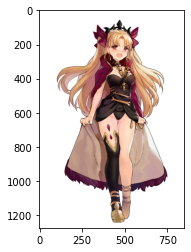

In [10]:
image_Ereshkigal = cv.imread('/content/drive/MyDrive/DataSet/Ereshkigal/1550733607779-291311951.jpg')
image_Ereshkigal = cv.cvtColor(image_Ereshkigal, cv.COLOR_BGR2RGB)
plt.imshow(image_Ereshkigal)

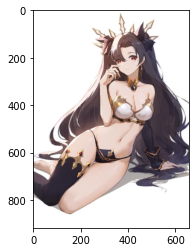

In [12]:
image_Ishtar = cv.imread('/content/drive/MyDrive/DataSet/Ishtar/RDT_20211217_0738381523374567326328075.jpg')
image_Ishtar = cv.cvtColor(image_Ishtar, cv.COLOR_BGR2RGB)
plt.imshow(image_Ishtar)

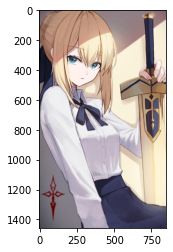

In [41]:
image_Saber = cv.imread('/content/drive/MyDrive/DataSet/Saber/artoria_pendragon_and_saber_fate_and_2_more_drawn_by_gnns__sample-cfb865e530ad1332ed9a9b66f99b733d.png')
image_Saber = cv.cvtColor(image_Saber, cv.COLOR_BGR2RGB)
plt.imshow(image_Saber)

In [14]:
data_dir = tf.keras.utils.image_dataset_from_directory('/content/DS')
data_dir = pathlib.Path('/content/DS')
print(data_dir)
print(os.path.abspath(data_dir))

Found 6400 files belonging to 4 classes.
/content/DS
/content/DS


In [15]:
image_count = len(list(data_dir.glob('*/*')))
total = list(data_dir.glob('*/*'))
print(image_count)

6400


In [16]:
Rins = list(data_dir.glob('Rin Tohsaka/*'))
Ereshkigal = list(data_dir.glob('Ereshkigal/*'))
Ishtar = list(data_dir.glob('Ishtar/*'))
Saber = list(data_dir.glob('Saber/*'))

In [17]:
batch_size = 32
img_height = 180
img_width = 180

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [20]:
class_names = train_ds.class_names

print(class_names)

['Ereshkigal', 'Ishtar', 'Rin Tohsaka', 'Saber']


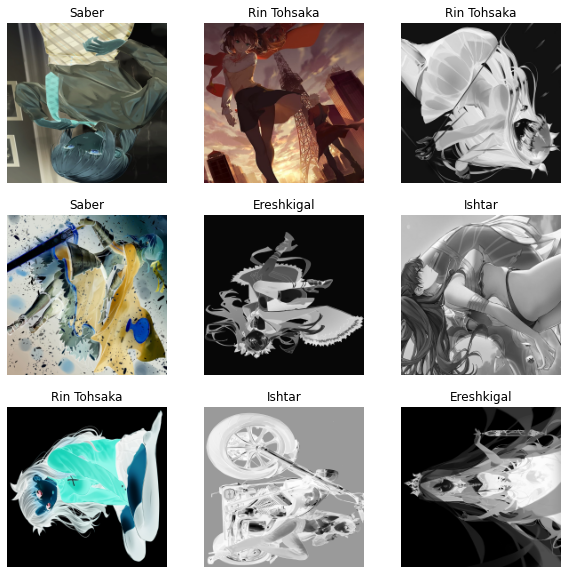

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
normalization_layer = layers.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8980393


In [27]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomContrast(factor=0.2),
    layers.RandomZoom(0.1),
  ]
)

In [28]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
160/160 [==============================] - 22s 66ms/step - loss: 1.3895 - accuracy: 0.3070 - val_loss: 1.2591 - val_accuracy: 0.4172
Epoch 2/10
160/160 [==============================] - 9s 56ms/step - loss: 1.1729 - accuracy: 0.4754 - val_loss: 1.0856 - val_accuracy: 0.5328
Epoch 3/10
160/160 [==============================] - 9s 56ms/step - loss: 0.9523 - accuracy: 0.6104 - val_loss: 0.8979 - val_accuracy: 0.6297
Epoch 4/10
160/160 [==============================] - 9s 56ms/step - loss: 0.7119 - accuracy: 0.7285 - val_loss: 0.6840 - val_accuracy: 0.7109
Epoch 5/10
160/160 [==============================] - 9s 56ms/step - loss: 0.5014 - accuracy: 0.8135 - val_loss: 0.4409 - val_accuracy: 0.8500
Epoch 6/10
160/160 [==============================] - 9s 55ms/step - loss: 0.3444 - accuracy: 0.8777 - val_loss: 0.3185 - val_accuracy: 0.8891
Epoch 7/10
160/160 [==============================] - 9s 56ms/step - loss: 0.2371 - accuracy: 0.9229 - val_loss: 0.2012 - val_accuracy: 0.935

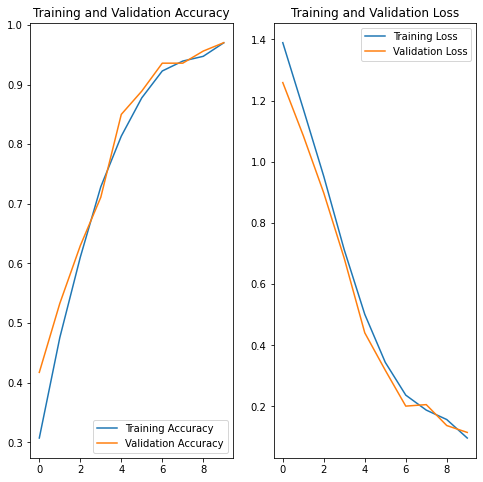

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# from google.colab import files
# file_to_predict = files.upload()

In [34]:
# for file_ in file_to_predict:
#     image_to_predict = cv.imread(file_,cv.IMREAD_COLOR)
#     plt.imshow(cv.cvtColor(image_to_predict, cv.COLOR_BGR2RGB))
#     plt.show()

In [37]:
img = cv.resize(image_Rin, (img_height,img_height))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Rin Tohsaka with a 53.42 percent confidence.


In [39]:
img = cv.resize(image_Ereshkigal, (img_height,img_height))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Ereshkigal with a 92.42 percent confidence.


In [40]:
img = cv.resize(image_Ishtar, (img_height,img_height))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Ishtar with a 49.50 percent confidence.


In [42]:
img = cv.resize(image_Saber, (img_height,img_height))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Saber with a 93.28 percent confidence.


In [43]:
layer_names = [layer.name for layer in model.layers]
layer_names.pop(0)
layer_names.pop(0)
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout',
 'flatten',
 'dense',
 'dense_1']

In [44]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs.pop(0)
layer_outputs.pop(0)

<KerasTensor: shape=(None, 180, 180, 3) dtype=float32 (created by layer 'rescaling_1')>

In [45]:
feature_map_model = tf.keras.models.Model(model.input, layer_outputs)

In [47]:
input = image_Rin.copy()
input = cv.resize(input, (img_height, img_height))
input = input.reshape((1,) + input.shape)                   

In [48]:
feature_maps = feature_map_model.predict(input)

In [49]:
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d is =======>> (1, 180, 180, 16)
The shape of the max_pooling2d is =======>> (1, 90, 90, 16)
The shape of the conv2d_1 is =======>> (1, 90, 90, 32)
The shape of the max_pooling2d_1 is =======>> (1, 45, 45, 32)
The shape of the conv2d_2 is =======>> (1, 45, 45, 64)
The shape of the max_pooling2d_2 is =======>> (1, 22, 22, 64)
The shape of the dropout is =======>> (1, 22, 22, 64)
The shape of the flatten is =======>> (1, 30976)
The shape of the dense is =======>> (1, 128)
The shape of the dense_1 is =======>> (1, 4)


In [50]:
activation = feature_map_model(input)
a = activation[0]
a.shape

TensorShape([1, 180, 180, 16])

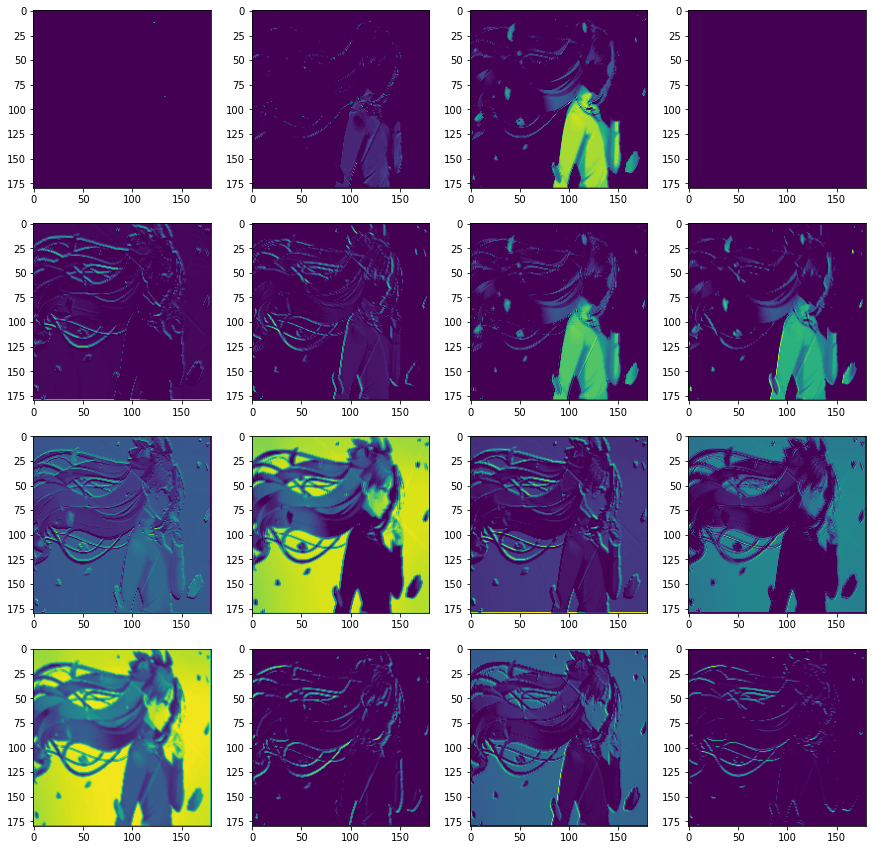

In [51]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(a[0,:, :, i])
plt.show()

In [52]:
model.layers

In [53]:
blocks = [ 2, 3, 4 , 5, 6, 7, 10]
outputs = [model.layers[i].output for i in blocks]

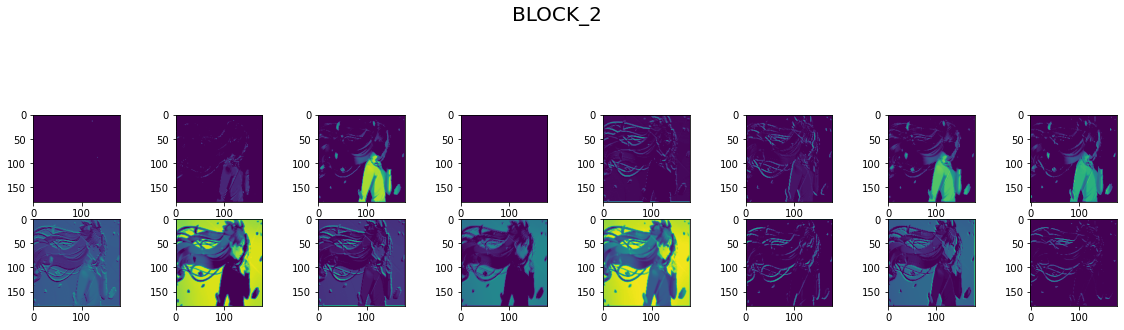

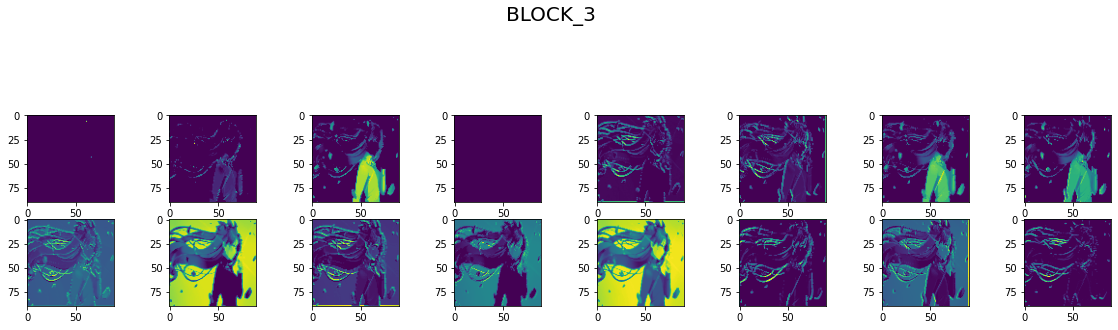

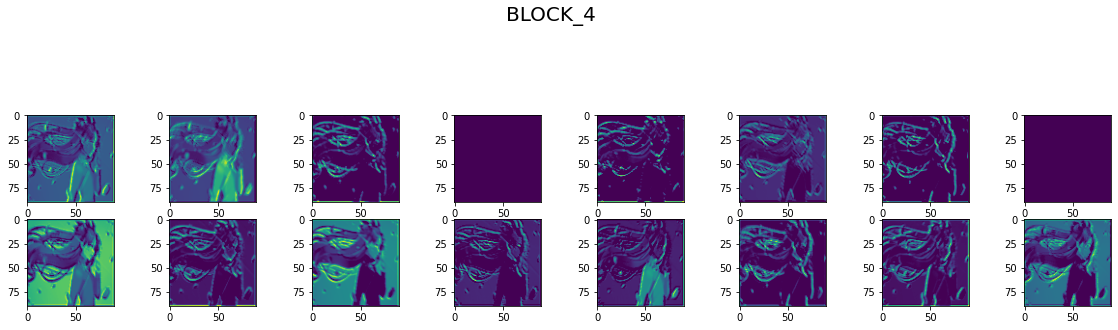

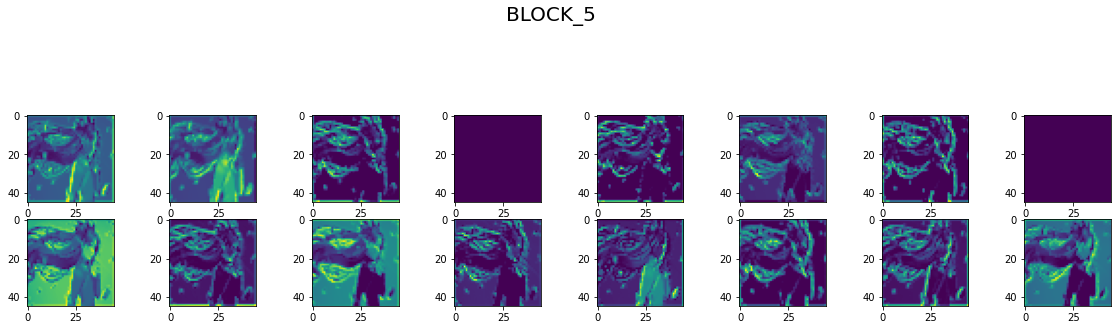

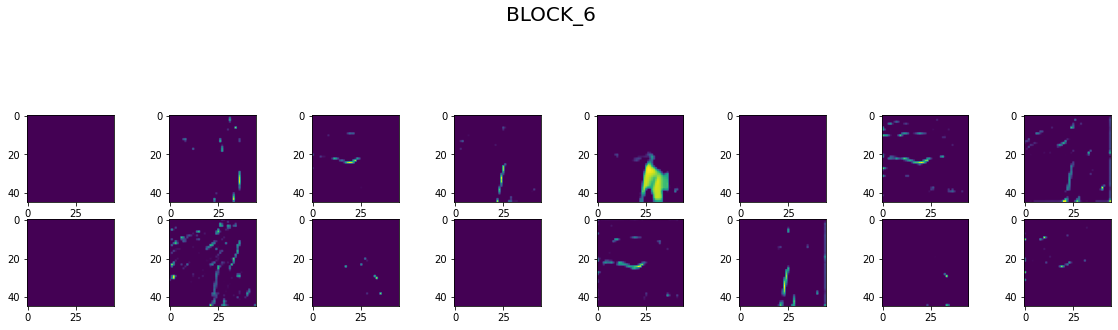

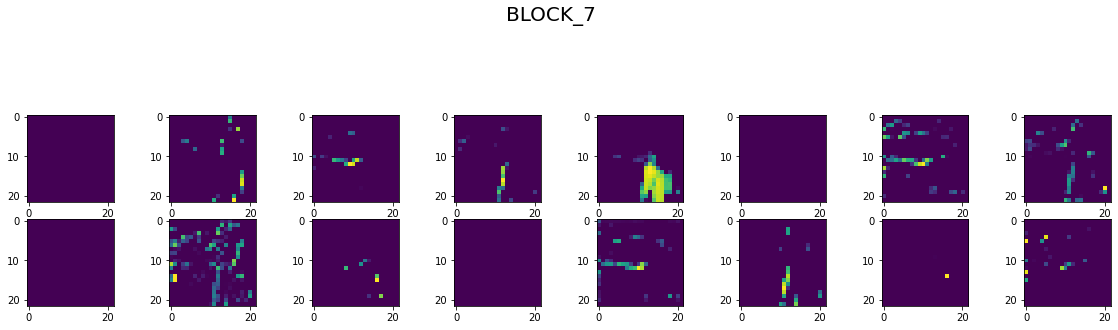

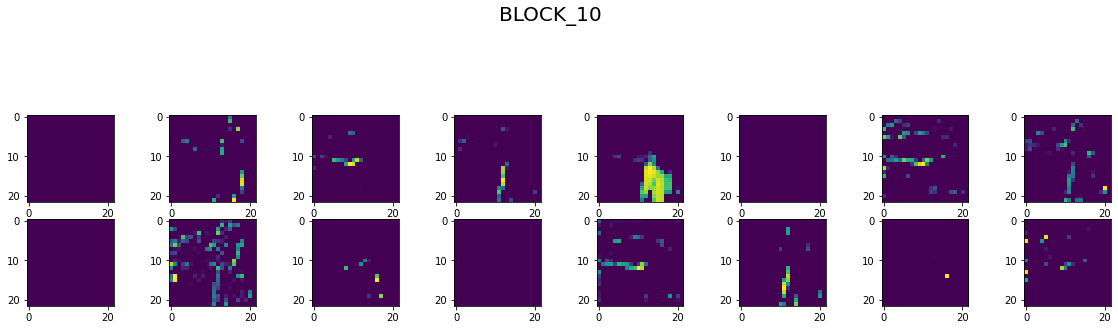

In [54]:
for i,fmap in zip(blocks,feature_maps):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,a.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1])
    
plt.show()

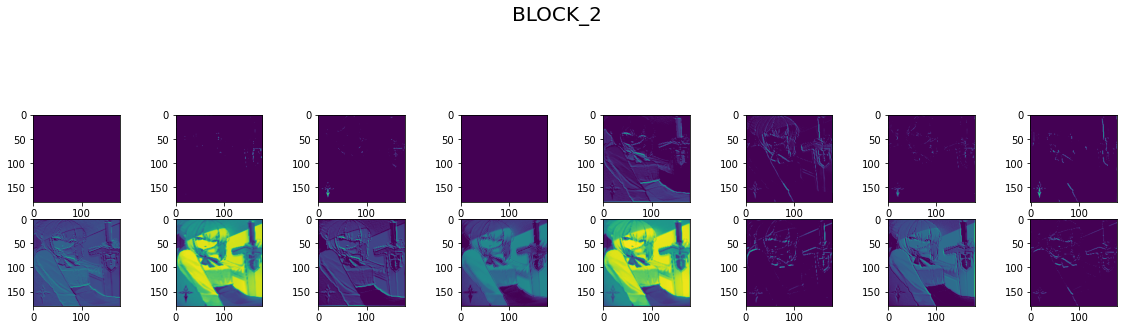

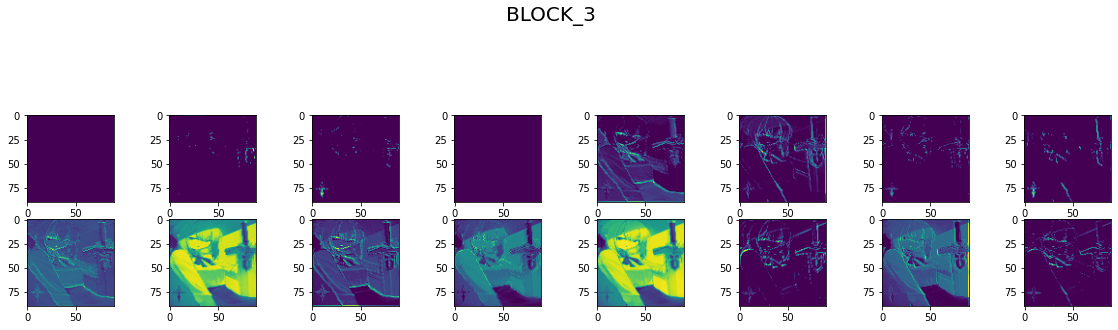

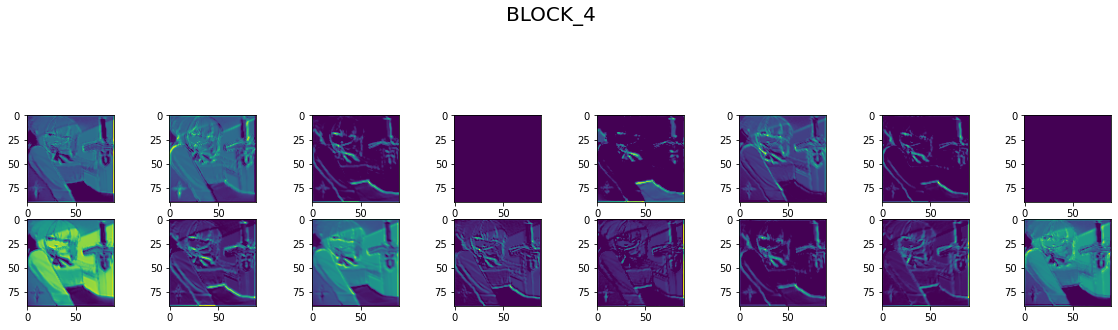

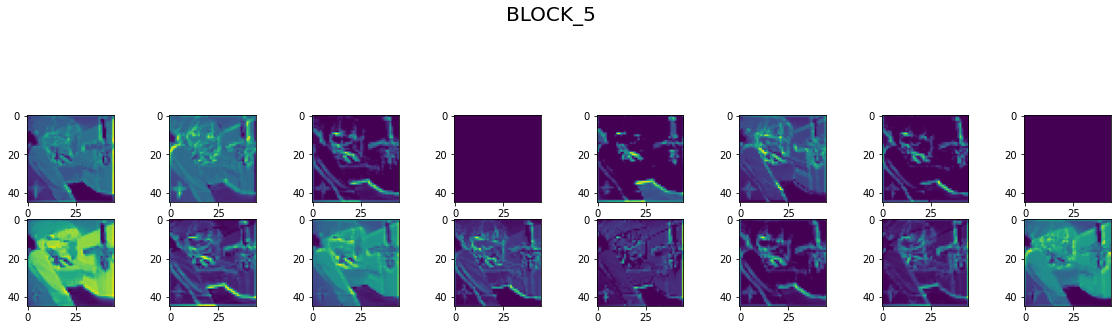

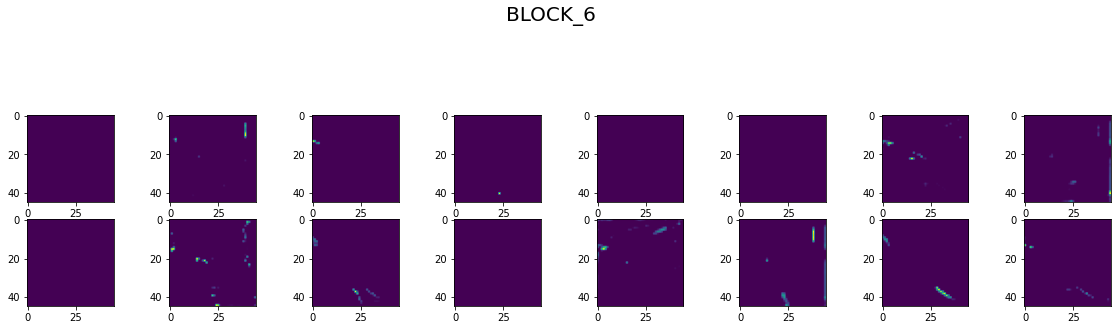

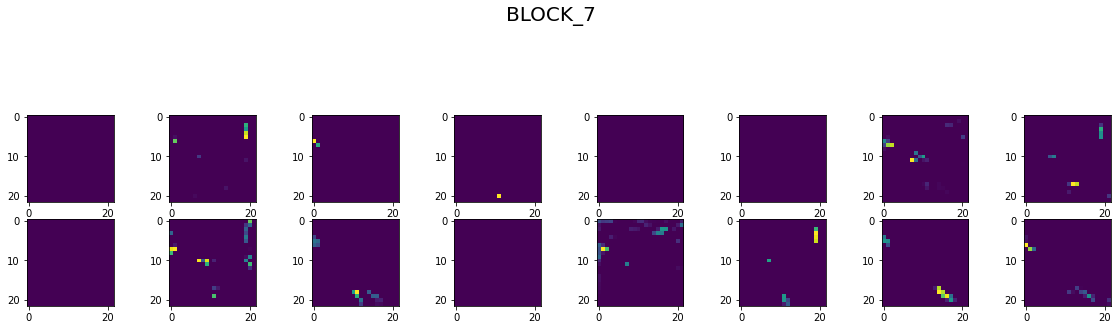

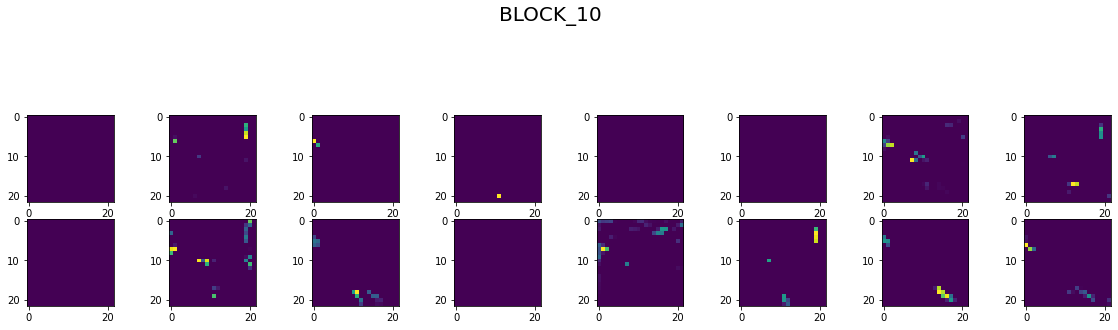

In [55]:
input = image_Saber.copy()
input = cv.resize(input, (img_height, img_height))
input = input.reshape((1,) + input.shape)     
feature_maps = feature_map_model.predict(input)      
activation = feature_map_model(input)
a = activation[0]
a.shape  
for i,fmap in zip(blocks,feature_maps):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,a.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1])
    
plt.show()      

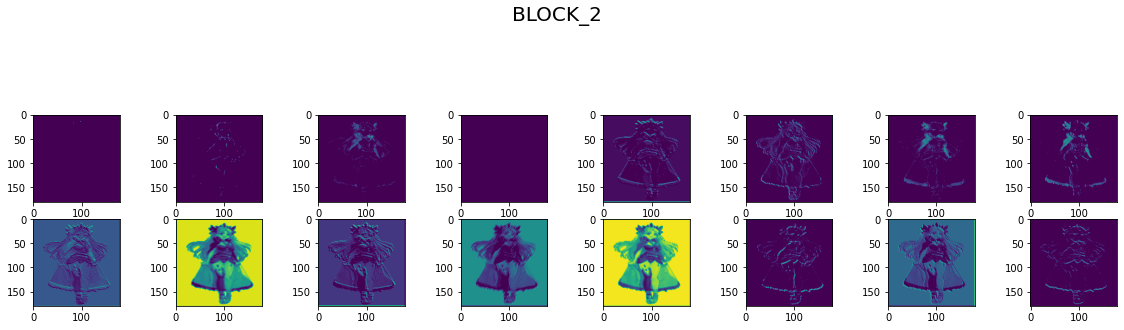

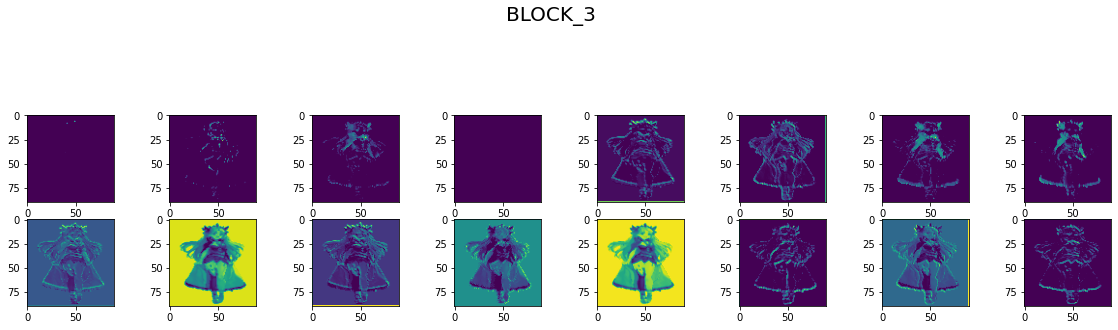

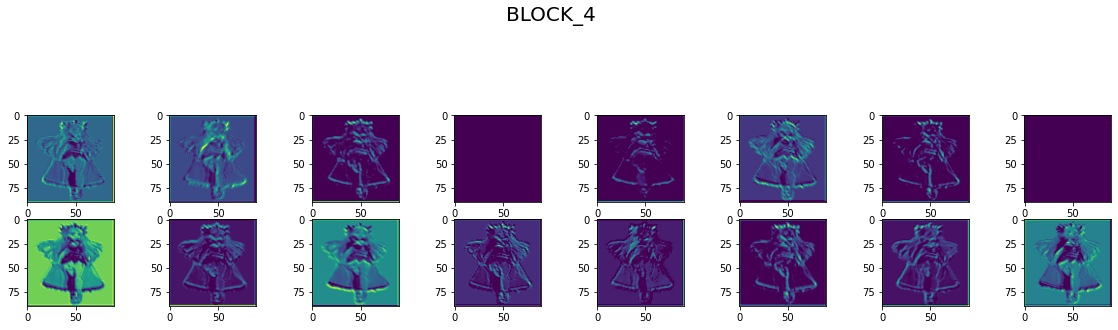

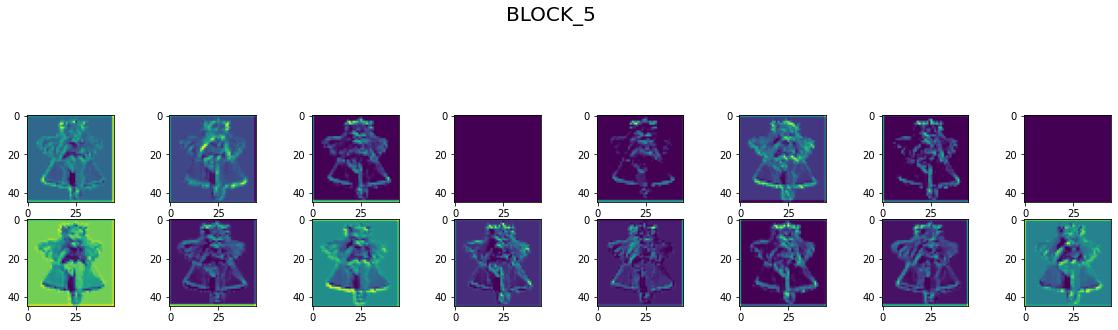

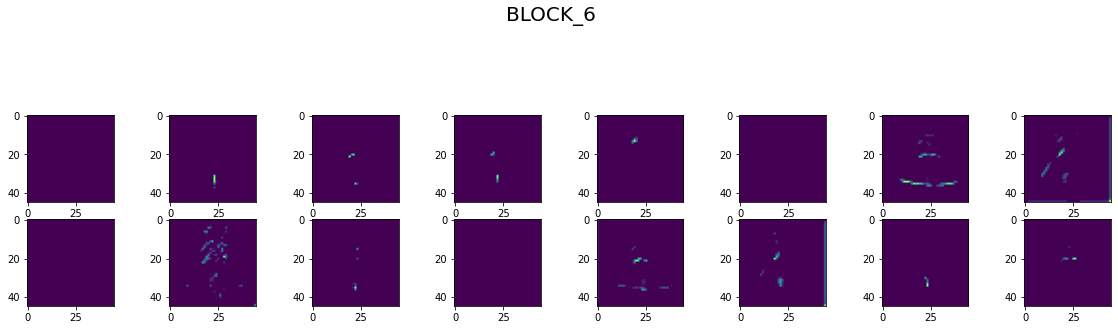

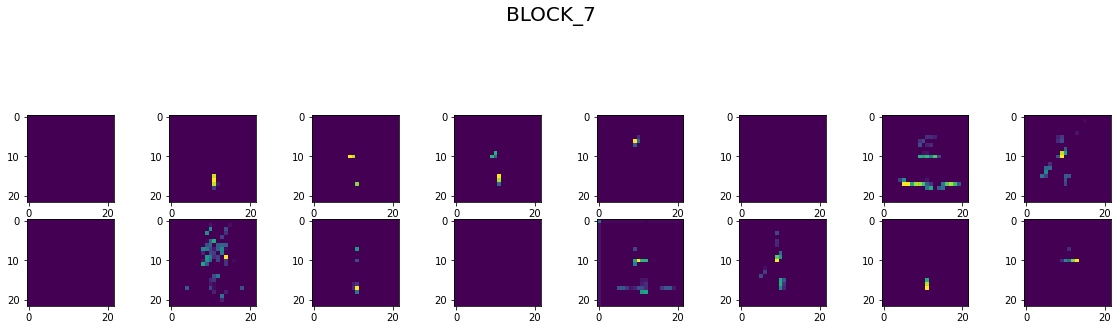

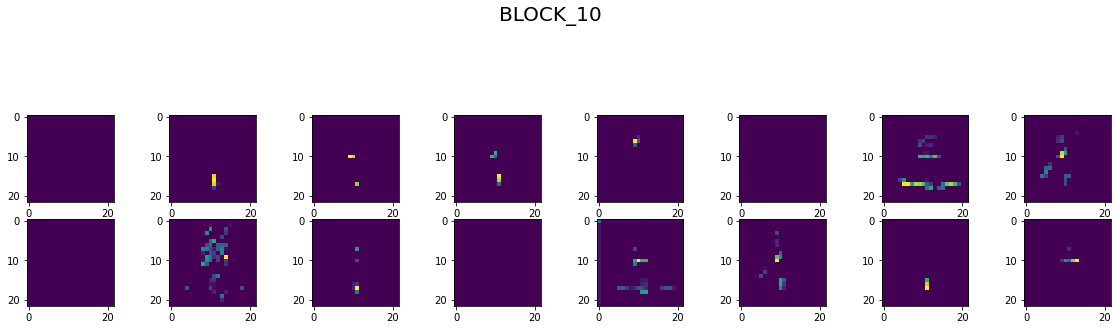

In [59]:
input = image_Ereshkigal.copy()
input = cv.resize(input, (img_height, img_height))
input = input.reshape((1,) + input.shape)     
feature_maps = feature_map_model.predict(input)      
activation = feature_map_model(input)
a = activation[0]
a.shape  
for i,fmap in zip(blocks,feature_maps):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,a.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1])
    
plt.show()      